
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Автор материала: Юрий Кашницкий (@yorko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 8 (демо)
## <center> Реализация алгоритмов онлайн-обучения

Вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD). [Веб-форма](https://docs.google.com/forms/d/1xlbc0CaUaNpVs-fhxkHUe61AtsvS_aDqQ0CLFxs6UDA) для ответов.

## План домашнего задания
    1. Линейная регрессия и SGD
    2. Логистическая регрессия и SGD
    3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

В [статье](https://habrahabr.ru/company/ods/blog/326418/) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

##  1. Линейная регрессия и SGD

In [14]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.metrics import log_loss, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import scipy.optimize as optimize

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [2]:
class SGDRegressor(BaseEstimator):
    def __init__(self, 
                 w = None, 
                 n_iter = 1000,
                 eta=0.001,
                 mse_= None):
        self.w = w
        self.n_iter = n_iter
        self.eta = eta
        self.mse_= mse_
        
        self.w0_by_iter = []
        self.w1_by_iter = []
        self.mse_by_iter = []
    
    def fit(self, X, y):
        global w_

        n, k = X.shape
        #  инициализируем веса нулями
        self.w = np.zeros(2) #random.randn(k + 1 if self.n_iter else k)
        
        #добавлеяем столбец из единиц
        X_train = np.hstack((X, np.ones((n, 1)))) # if self.fit else X  

        for iter_num in range(self.n_iter):
            self.w[0] = self.w[0]-self.eta*2/n*(y[iter_num]-(self.w[0]+self.w[1])*X[iter_num])
            self.w[1] = self.w[1]-self.eta*2/n*(y[iter_num]-(self.w[0]+self.w[1])*X[iter_num])*X[iter_num]
            
            self.w0_by_iter.append(self.w[0])
            self.w1_by_iter.append(self.w[1])

            def mse(params):
                self.w[0], self.w[1] = params
                self.mse_ = np.sqrt(1/n*(y[iter_num]-(self.w[0]+self.w[1]*X[iter_num]))**2)
                self.mse_by_iter.append(self.mse_)
                return self.mse_
        
        result = optimize.minimize(mse, self.w, method = 'Nelder-Mead')
        w_ = result.x
        return w_, self
    
    def predict(self, X):
        
        a, b = X.shape       
        X_train = np.hstack((X, np.ones((a, 1)))) 
        
        predictions = []
        for i in range(a):
            p = 1/(1+np.exp(-(y[i]-(w_[0]+w_[1]*X[i]))))
            predictions.append(p)
        return predictions    


Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [3]:
data_demo = pd.read_csv("weights_heights.csv")

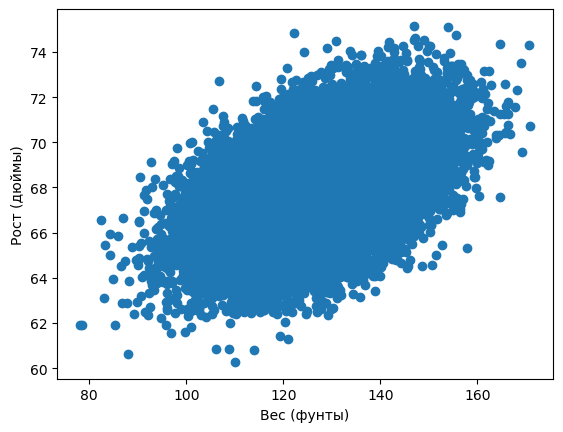

In [4]:
plt.scatter(data_demo["Weight"], data_demo["Height"])
plt.xlabel("Вес (фунты)")
plt.ylabel("Рост (дюймы)");

In [5]:
X, y = data_demo["Weight"].values, data_demo["Height"].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

In [8]:
X_train_scaled 

array([[-0.60294577],
       [-1.38028811],
       [ 0.37833715],
       ...,
       [-0.59374395],
       [ 1.27525138],
       [-0.09353415]])

In [9]:
X_valid_scaled 

array([[-1.83209135],
       [-0.97031133],
       [-0.77148479],
       ...,
       [ 0.5453066 ],
       [-0.4912476 ],
       [-0.14913314]])

In [10]:
X_train_scaled.shape, X_valid_scaled.shape

((17500, 1), (7500, 1))

In [11]:
y_train.shape, y_valid.shape

((17500,), (7500,))

In [12]:
n, k = X_train_scaled.shape
print(n)

17500


In [13]:
X_train = np.hstack((X_train_scaled , np.ones((n, 1))))

In [14]:
X_train

array([[-0.60294577,  1.        ],
       [-1.38028811,  1.        ],
       [ 0.37833715,  1.        ],
       ...,
       [-0.59374395,  1.        ],
       [ 1.27525138,  1.        ],
       [-0.09353415,  1.        ]])

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

In [15]:
myRegressor = SGDRegressor()

In [16]:
myRegressor.fit(X_train_scaled, y_train)

(array([59.22514247, -1.33411195]),
 SGDRegressor(mse_=array([8.95003197e-08]), w=array([59.22514247, -1.33411195])))

In [17]:
myRegressor.predict(X_train_scaled)

[array([0.99683922]),
 array([0.99997101]),
 array([0.99997696]),
 array([0.99963469]),
 array([0.9999232]),
 array([0.99902705]),
 array([0.99999362]),
 array([0.99998571]),
 array([0.99990698]),
 array([0.99568168]),
 array([0.99951874]),
 array([0.99988581]),
 array([0.99943726]),
 array([0.99987166]),
 array([0.99995894]),
 array([0.99997406]),
 array([0.99918645]),
 array([0.99964889]),
 array([0.999994]),
 array([0.99977936]),
 array([0.99946745]),
 array([0.99998602]),
 array([0.95253464]),
 array([0.99995342]),
 array([0.99971766]),
 array([0.9975881]),
 array([0.9999912]),
 array([0.99989997]),
 array([0.9999157]),
 array([0.9801391]),
 array([0.99998846]),
 array([0.99938264]),
 array([0.99965566]),
 array([0.99999319]),
 array([0.99982193]),
 array([0.99998243]),
 array([0.99935474]),
 array([0.99964542]),
 array([0.99977505]),
 array([0.99743779]),
 array([0.99996524]),
 array([0.99902834]),
 array([0.99994229]),
 array([0.99966618]),
 array([0.99703596]),
 array([0.9999041

Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

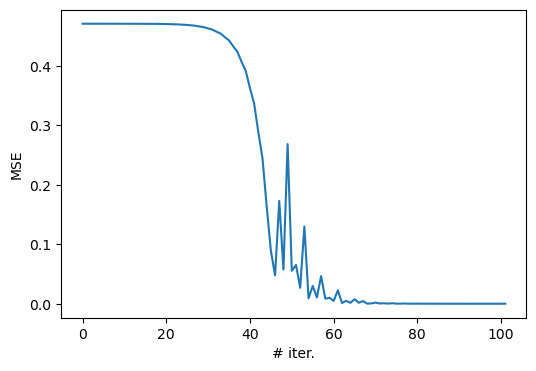

In [18]:
plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(range(len(myRegressor.mse_by_iter)), myRegressor.mse_by_iter);
plt.xlabel('# iter.')
plt.ylabel('MSE');

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [18]:
def mse(params):   
    myRegressor.w0_by_iter, myRegressor.w1_by_iter = params
    for i in range(myRegressor.n_iter):
        mse = np.sqrt(1/X_train_scaled.shape[0]*(y_train[i]-(myRegressor.w0_by_iter+myRegressor.w1_by_iter*X_train_scaled[i]))**2)
    return mse

initial_guess = [0, 0]
result = optimize.minimize(mse, initial_guess, method = 'Nelder-Mead')

print(mse(result.x), result.x)
print(mse(w_), w_)

[3.16853289e-08] [ 16.71939139 -19.83315455]
[8.95003197e-08] [59.22514247 -1.33411195]


Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

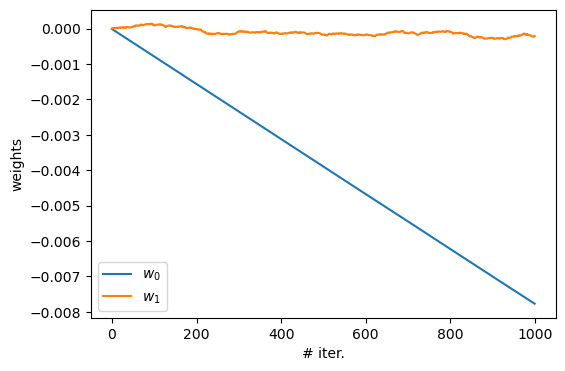

In [29]:
plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(range(len(myRegressor.w0_by_iter)), myRegressor.w0_by_iter, label='$w_0$');
plt.plot(range(len(myRegressor.w1_by_iter)), myRegressor.w1_by_iter, label='$w_1$');
plt.xlabel('# iter.')
plt.ylabel('weights')
plt.legend()

Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [19]:
myRegressor2 = SGDRegressor()

In [20]:
myRegressor2.fit(X_valid_scaled, y_valid)

(array([65.00983742, -1.93679804]),
 SGDRegressor(mse_=array([5.42245536e-07]), w=array([65.00990457, -1.93678161])))

Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
linreg = LinearRegression()

In [23]:
linreg.fit(X_valid_scaled, y_valid)

LinearRegression()

In [24]:
mean_squared_error(y_valid, linreg.predict(X_valid_scaled))

2.6704867808580857

<font color='red'>Вопрос 1.</font> В каком знаке после разделителя отличаются MSE линейной регрессии и `SGDRegressor` для отложенной выборки?
 - 2
 - 3
 - 4
 - 5

## 2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [27]:
A = [[6],
      [8]]
B = [[1, 3]]
print(np.dot(B,A))

[[30]]


In [35]:
w = np.zeros(4).Tr
print(w)

[0. 0. 0. 0.]


In [34]:
B = [[1, 3],
      [5, 7]]
print(B[0])

[1, 3]


In [49]:
zip(range(5), range(8))

In [99]:
class SGDClassifier(BaseEstimator):
    def __init__(self, 
                 w = None, 
                 n_iter = 10,
                 eta=0.001,
                 mse_= None,
                 loss_=None,
                 C=1):
        self.w = w
        self.n_iter = n_iter
        self.eta = eta
        self.mse_= mse_
        self.loss_ = loss_
        self.C = C
        
        self.weights = []
        self.mse_by_iter = []
        self.log_loss = []
    
    def sigma(self, z):
        z = z.flatten()
        z[z > 100] = 100
        z[z < -100] = -100
        return 1.0 / (1 + np.exp(-z))

    def fit(self, X, y):
        global w_, X_train

        l, d = X.shape
        #  инициализируем веса нулями
        self.w = np.zeros(d+1) 
        
        #добавлеяем слева столбец из единиц
        X_train = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1) # if self.fit else X  
        
        for iter_num in range(self.n_iter):
            for i, j in zip(range(l), range(d+1)):
                self.w[j] = self.w[j]+self.eta*(self.C*y[j]*X_train[i, j]*self.sigma(y[i]*self.w@X_train[j,:])-self.w[j])

                self.weights.append(self.w[j])

                def mse(params):
                    self.weights = params
                    self.mse_ = np.sqrt(1/l*(y[j]-(self.weights@X_train[j,:]))**2)
                    self.mse_by_iter.append(self.mse_)
                    return self.mse_
            
            self.loss_ = np.log(1+np.exp(-(y[i]*self.w@X_train[j,:])))
            self.log_loss.append(self.loss_)
        
        result = optimize.minimize(mse, self.w, method = 'Nelder-Mead')
        w_ = result.x

        return w_, self
    
    def predict_proba(self, X, y):
        global predictions
        
        a, b = X.shape
        #  инициализируем веса нулями
        self.w = np.zeros(b+1) 
        
        #добавлеяем слева столбец из единиц
        X_train = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        
        predictions = []
        for j in range(b+1):
            var = w_@X_train[j,:]
        for i in range(a):
            p = 1/(1+np.exp(-(y[i]*var)))
            predictions.append(p)
        return predictions  
    
    def predict(self, X, y):
        for s in range(X.shape[0]):
            predict = [-1 if i > 0.5 else 1 for i in predictions]
        return predict


Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [49]:
from sklearn.datasets import load_breast_cancer

In [50]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

In [51]:
cancer.feature_names[9]

'mean fractal dimension'

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [52]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [53]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [54]:
X_train_scaled.shape, X_valid_scaled.shape

((398, 30), (171, 30))

In [22]:
X.shape

(569, 30)

In [37]:
c = np.concatenate((np.ones((X_train_scaled.shape[0], 1)), X_train_scaled), axis=1)
c.shape

(398, 31)

In [47]:
d = c[1,:]
d.shape

(31,)

In [43]:
a = X_train_scaled[0:X_train_scaled.shape[1]+1, 1]
b = np.ones((X_train_scaled.shape[1]+1, 1))
a.shape, b.shape

((31,), (31, 1))

In [44]:
a@b, (a@b).shape

(array([1.34444847]), (1,))

In [45]:
y[5]*a@b

array([-1.34444847])

In [36]:
w = np.zeros(X_train_scaled.shape[0]+1)
x = X_train_scaled[:,1]
w.shape, x.shape

((399,), (398,))

In [95]:
np.dot()

(398, 398)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [100]:
myClassifier = SGDClassifier()

In [101]:
myClassifier.fit(X_train_scaled, y_train)

(array([ 0.0222432 , -0.02730749, -0.13268604, -0.00304665, -0.15385209,
        -0.0004403 , -0.08324349, -0.00167986, -0.03264908, -0.09236066,
         0.04690531,  0.08214222, -0.00093469,  0.00595549, -0.00574319,
        -0.00024188,  0.124733  ,  0.00135468,  0.07555124,  0.0130641 ,
         0.00597781, -0.03607624, -0.07445053, -0.11567866, -0.06702143,
        -0.06856012, -0.01789494, -0.00886359,  0.00686937, -0.02674461,
         0.06747536]),
 SGDClassifier(loss_=0.6611762997061114, mse_=3.708065129802595e-06,
               w=array([-0.00495371, -0.00153663, -0.0050614 ,  0.00161309, -0.01689823,
        -0.00691049, -0.00627049, -0.0017877 , -0.00348437, -0.00892747,
        -0.00444408, -0.00229337,  0.00211884, -0.00118049, -0.00230508,
        -0.00032914, -0.011155  , -0.00070762, -0.00753366, -0.00196702,
         0.00599546, -0.00307939, -0.00610541, -0.00540234, -0.00467419,
        -0.0054215 , -0.00336312,  0.00140916, -0.00424788,  0.00173262,
        -0.00380

In [87]:
len(myClassifier.predict_proba(X_train_scaled, y_train)), len(myClassifier.predict(X_train_scaled, y_train))

(398, 398)

In [88]:
len(myClassifier.predict_proba(X_valid_scaled, y_valid)), len(myClassifier.predict(X_valid_scaled, y_valid))

(171, 171)

Постройте график изменения log_loss.

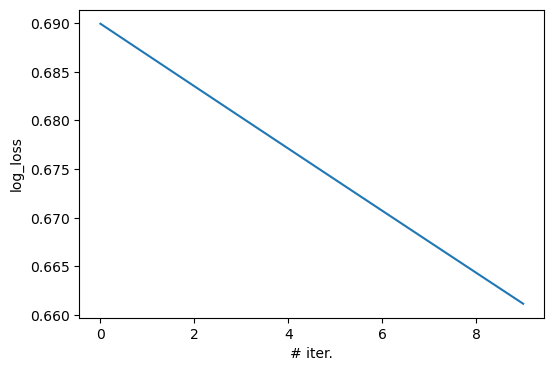

In [62]:
plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(range(len(myClassifier.log_loss)), myClassifier.log_loss);
plt.xlabel('# iter.')
plt.ylabel('log_loss');

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

In [92]:
myClassifier2 = SGDClassifier(C=1000, n_iter=10)

In [93]:
myClassifier2.fit(X_train_scaled, y_train)

(array([ 1.14116739e+00,  1.03600049e+00,  9.18482795e-01, -7.47052650e-02,
         4.76098893e-01,  6.25033072e-01,  4.32849726e-02,  1.82075372e-01,
         1.39935642e+00,  1.60853726e-01,  8.71383726e-02,  7.66459398e-01,
        -7.02547350e-02,  2.68149428e+00,  1.26660545e+00,  5.23041849e-01,
         9.43000231e-04,  2.65151275e-01,  3.38370401e-01,  1.53614649e-03,
        -1.60966983e+00,  4.29073706e-01, -3.42170432e-01,  3.64545554e-02,
         2.28010239e-01,  4.85875422e-02, -5.88018475e+00, -9.75868104e-02,
         1.92662657e-02, -1.66138522e-01,  1.10304098e-02]),
 SGDClassifier(C=1000, loss_=10.504895269383013, mse_=1.2583209477052214e-07,
               w=array([ 7.21291371e-01,  7.11145864e-01,  7.96901645e-01, -7.90641804e-02,
         5.65155802e-01,  8.23078338e-01,  4.55245279e-02,  1.17330861e-01,
         2.22047814e+00,  1.42499121e-01,  9.01623281e-02,  8.68356995e-01,
        -1.62100602e-01,  1.94732775e+00,  1.01491598e+00,  2.47538553e-01,
         

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - worst smoothness
 - worst concavity
 - concave points error
 - concavity error
 - compactness error
 - worst fractal dimension
 - radius error

In [92]:
max_weight = max(myClassifier.weights)
idx_max_weight = max(enumerate(myClassifier.weights),key=lambda x: x[1])[0]
print('Наиболее влиятельный признак:', cancer.feature_names[idx_max_weight+1])

Наиболее влиятельный признак: concave points error


Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [83]:
len(myClassifier.predict(X_valid_scaled, y_valid)), len(myClassifier.predict_proba(X_valid_scaled, y_valid))

(171, 171)

In [102]:
roc_auc_score(y_valid, myClassifier.predict(X_valid_scaled, y_valid))

1.0

In [185]:
from sklearn.linear_model import LogisticRegression

In [186]:
logit = LogisticRegression(random_state=17)

In [187]:
logit.fit(X_train_scaled, y_train)

LogisticRegression(random_state=17)

In [193]:
roc_auc_score(y_valid, logit.predict_proba(X_valid_scaled)[:, 1])

0.9885245901639343

## 3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. С этой задачей мы знакомы по 4 и 8 темам курса. Данные можно скачать [отсюда](https://drive.google.com/open?id=1xq4l5c0JrcxJdyBwJWvy0u9Ad_pvkJ1l).

Импортируем файлы, и обучим на имеющихся данных `CountVectorizer`

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import load_files #будем подгружать файлы с данными
import os

In [2]:
# поменяйте путь к файлу
#reviews_train = load_files('X_train.txt')
PATH_TO_DATA = 'D:\python\DATAS\imdb_reviews'
#ext_train, y_train = reviews_train.data, reviews_train.target

In [3]:
train_reviews = load_files(os.path.join(PATH_TO_DATA, 'train'))

In [4]:
test_reviews = load_files(os.path.join(PATH_TO_DATA, 'test'))

In [5]:
import pandas as pd 
targets = pd.DataFrame(train_reviews.target)
targets.value_counts()

0    12500
1    12500
dtype: int64

In [11]:
y_train, y_test = train_reviews.target, test_reviews.target

In [ ]:
reviews_test = load_files(
    "/Users/y.kashnitsky/Documents/Machine_learning/datasets/imdb_reviews/test"
)
text_test, y_test = reviews_test.data, reviews_test.target

Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [7]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(train_reviews.data)
X_test = cv.transform(test_reviews.data)

CPU times: total: 24.6 s
Wall time: 24.7 s


In [8]:
X_train.shape, X_test.shape

((25000, 1513832), (25000, 1513832))

Обучите на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только укажите `random_state`=17) и посчитайте ROC AUC на тестовой выборке. Замерьте время обучения модели. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне.

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
logit = LogisticRegression(random_state=17)

In [16]:
%%time
logit.fit(X_train, y_train)

CPU times: total: 1min 59s
Wall time: 31.9 s


C:\Users\ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=17)

In [15]:
roc_auc_score(y_test, logit.predict_proba(X_test)[:, 1])

0.957701504

Теперь перейдем к онлайн-алгоритму. Мы написали свой `SGDClassifier` и принцип его работы поняли, надо еще немного постараться, чтобы сделать его эффективным, например, сделать поддержку разреженных данных. Но мы теперь перейдем к `sklearn`-реализации SGD-алгоритма. Прочитайте документацию [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), сделайте выводы, чем `SGDClassifier` из `Sklearn` более продвинут, чем наша реализация SGD-классификатора. 

<font color='red'>Вопрос 4.</font> Чем `sklearn`-реализация стохастического классификатора более продвинута, чем `SGDClassifier`, который мы реализовали? Отметьте все подходящие варианты.
 - Изменяемый шаг градиентного спуска
 - Реализован линейный SVM
 - Реализована ранняя остановка во избежание переобучения
 - Есть распараллеливание по процессорам
 - Можно обучать LASSO
 - Поддерживается онлайн-обучение деревьев решений
 - Поддерживается mini-batch подход (обновление весов по нескольким объектом сразу, а не по одному)


Проведите 100 итераций SGD-логрегрессии (опять `random_state`=17) на той же выборке. Опять замерьте время обучения модели и обратите внимание, насколько оно меньше, чем время обучения логистической регрессии.

In [17]:
from sklearn.linear_model import SGDClassifier

In [43]:
sgdClf = SGDClassifier(random_state=17, loss='log', max_iter=100)

In [44]:
%%time
sgdClf.fit(X_train, y_train)

CPU times: total: 1.73 s
Wall time: 1.13 s


SGDClassifier(loss='log', max_iter=100, random_state=17)

In [47]:
roc_auc_score(y_test, sgdClf.predict_proba(X_test)[:, 1])

0.9529982944

In [45]:
sgdClf.predict_proba(X_test)

array([[3.78499572e-02, 9.62150043e-01],
       [9.99999929e-01, 7.07480156e-08],
       [3.70809542e-02, 9.62919046e-01],
       ...,
       [9.99997248e-01, 2.75162193e-06],
       [9.99983639e-01, 1.63608797e-05],
       [9.99998757e-01, 1.24250823e-06]])

In [31]:
from sklearn.calibration import CalibratedClassifierCV

In [38]:
calibrator = CalibratedClassifierCV(sgdClf, cv='prefit')
model=calibrator.fit(X_train, y_train)

y_train_pred = model.predict_proba(X_train)
y_test_pred = model.predict_proba(X_test)

<font color='red'>Вопрос 5.</font> В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора `Sklearn` с логистической функцией потерь?
 - 2
 - 3
 - 4
 - 5